In [1]:
import tensorflow as tf
from lxml import etree
import os
import cv2
from PIL import Image
import numpy as np
import skimage
import random

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Writing

In [261]:
# characters = '0123456789+-*/=()'
characters = '0123456789'
width, height, n_len, n_class = 400, 40, 10, len(characters) + 1


def generate():
    ds = '0123456789'
    ts = ['{}{}{}{}{}', '({}{}{}){}{}', '{}{}({}{}{})']
    os = '+-*/'
    # os = ['+', '-', 'times', 'div']
    cs = [random.choice(ds) if x % 2 == 0 else random.choice(os) for x in range(5)]
    return random.choice(ts).format(*cs)


def get_img_by_char(char, base_path=r'F:\number_ok1'):
    """
    get a img by giving char
    :param char:
    :param base_path:
    :return:
    """
    opdict = {'+': 10, '-': 11, '*': 12, '/': 13, '=': 14, '(': 15, ')': 16}
    if char in opdict.keys():
        char = opdict[char]
    path = os.path.join(base_path, str(char))
    files = os.listdir(path)

    rdm = random.randint(0, len(files) - 1)

    if rdm >= len(files):
        print(path, len(files), rdm)

    file = files[rdm]
    path = os.path.join(path, file)
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


def get_sequence_img(chars):
    """

    :param chars:
    :return:
    """
    x = get_img_by_char(chars[0])
    for i in range(1, len(chars)):
        x = np.hstack([x, get_img_by_char(chars[i])])
    x = cv2.resize(x, (width, height))
#     x = skimage.util.random_noise(x, mode='gaussian', clip=True)
    return x

In [262]:
def gen():
    """

    :return:
    """
    random_str = ''.join([random.choice(characters) for j in range(n_len)])
    #             random_str = '60/3=20'
    img = np.array(get_sequence_img(random_str))
    img = img.astype(np.uint8)
    return img, [characters.find(x) for x in random_str]

In [263]:
def _bytes_feature(value):
    img_bytes = value.tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes]))


def _float32_feature(value):
    return tf.train.Feature(float32_list=tf.train.FloatList(value=[value]))


def _bytes_feature_with_list(value):
    value = [str(v) for v in value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(' '.join(value), encoding='utf8')]))


def _write_features(features, tf_writer):
    tf_features = tf.train.Features(feature=features)
    tf_example = tf.train.Example(features=tf_features)
    tf_serialized = tf_example.SerializeToString()

    tf_writer.write(tf_serialized)

In [264]:
def tfrecord(path, batch_size=128):
    """

    :param batch_size:
    :return:
    """
    with tf.python_io.TFRecordWriter(path=path) as tf_writer:
        for i in range(batch_size):
            features = {}
            img, y = gen()

            features['image'] = _bytes_feature(img)
            features['label'] = _bytes_feature_with_list(y)

            _write_features(features, tf_writer)

In [265]:
tfrecord('./tfrc.tfrecord', batch_size=1024)

## Reading

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt

In [246]:
def _read_features(example_proto):
    """

    :param example_proto:
    :return:
    """
    dic = dict()
    dic['image'] = tf.FixedLenFeature(shape=[], dtype=tf.string)
    dic['label'] = tf.FixedLenFeature(shape=[], dtype=tf.string)

    parse_example = tf.parse_single_example(
        serialized=example_proto, features=dic)
    
    img = parse_example['image']
    y = parse_example['label']

    img = tf.decode_raw(parse_example['image'], out_type=tf.uint8)

    return img, y
#     return img

In [247]:
def tfrecord2img(path, epoch_batch_size=1):
    """

    :param example_proto:
    :return:
    """
    data = tf.data.TFRecordDataset(path)
    data = data.map(_read_features).batch(epoch_batch_size)

    iterator = data.make_one_shot_iterator()
    next_element = iterator.get_next()

    with tf.Session() as sess:
        img, y = sess.run(fetches=next_element)
#         img = sess.run(fetches=next_element)
        print(img)
        img = img.reshape(height, width)
        print(img.shape)
        plt.imshow(img)
        plt.show()
        
        y = list(map(lambda x: int(x), y[0].decode('utf8').split()))
        print('label', y)

[[0 0 0 ... 0 0 0]]
(40, 400)


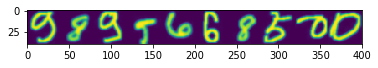

label [9, 8, 9, 5, 6, 6, 8, 5, 0, 0]


In [248]:
tfrecord2img('./tfrc.tfrecord', epoch_batch_size=1)

In [249]:
img, y = gen()
img = img.astype(np.uint8)

(40, 400)


In [252]:
bt = img.tobytes()
bt[:10]

b'\x01\x03\x02\x04\x02\x01\x02\x02\x02\x02'

In [268]:
with tf.Session() as sess:
    xx = 2222

In [269]:
xx

2222